# fit and predict

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.path as mpath

import json

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.linear_model import LinearRegression
from sklearn.mixture import GaussianMixture

%matplotlib inline

### Higher Dimensions

In [27]:
# load data
with open("./samples.json", "r") as f:
    data = f.read()
samples = json.loads(data)

with open('./preprocess.json', "r") as f:
    data = f.read()
map = json.loads(data)

# prepare train and test set
train_dataset = samples["Inputs"][:8000]
test_dataset = samples["Inputs"][8000:]

# prepare inputs and outputs
X = np.zeros((8000,2))
y = np.zeros((8000,))
for i, sample in enumerate(train_dataset):
    X[i, :] = [sample[0], sample[1]]
    # ["Carbon_Loss": 0, "Carbon_Stored": 1, "Decomposing_Microbes": 2, "Labile_Detritus": 3,
    # "Mineral": 4, "Soil_Loss": 5, "Soil_Mass": 6, "Stable_Detritus": 7]
    #                                               index below | is 0 means selecting carbon_loss
    carbon_losses = map[f'{sample[0]}_{sample[1]}_{sample[2]}'][0]
    y[i] = carbon_losses
    


# test
loss = 0
X_test = np.zeros((2000,2))
y_test = np.zeros((2000,))
for i, sample in enumerate(test_dataset):
    X_test[i, :] = [sample[0], sample[1]]
    carbon_losses = map[f'{sample[0]}_{sample[1]}_{sample[2]}'][0]
    y_test[i] = carbon_losses
    
# normalise
y_mean = y.mean()
y_std = y.std()
print("y_mean", y_mean)
print("Y_std", y_std)
y = (y - y_mean) / y_std
y_test = (y_test - y_mean) / y_std

y_mean 36.8931917285344
Y_std 7.385144641964149e-06


In [28]:
# def plot_gp_2D(gx, gy, mu, X_train, Y_train, title, i):
#     ax = plt.gcf().add_subplot(1, 3, i, projection='3d')
#     ax.plot_surface(gx, gy, mu.reshape(gx.shape), cmap=cm.bwr, linewidth=0.5, alpha=0.3, antialiased=False)
#     ax.scatter(X_train[:,0], X_train[0:,1], Y_train, c=Y_train, cmap=cm.seismic)

def plot_gp_2D(x, y, z, title, i):
    ax = plt.gcf().add_subplot(1, 2, i, projection='3d')
    ax.plot_trisurf(x, y, z, cmap=cm.bwr, linewidth=0.1, vmin=0, vmax=2000)
    ax.xaxis
    ax.set_title(title)


MSE  0.09641735141441293


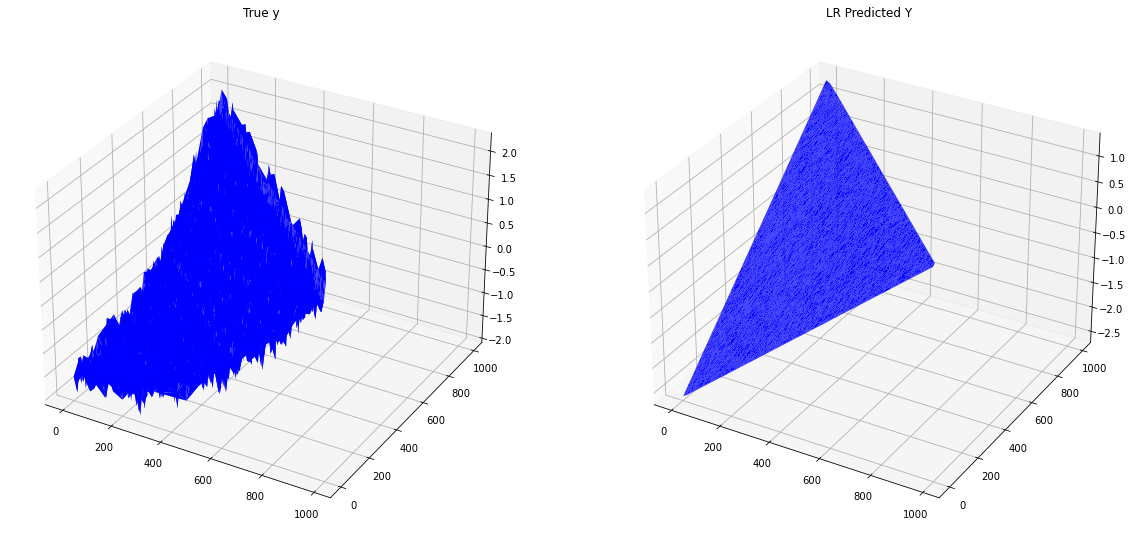

In [29]:
plt.figure(figsize=(20,10))

# True y
plot_gp_2D(X[:, 0], X[:, 1], y, f'True y', 1)

# Linear regression
lr = LinearRegression().fit(X, y)
Y = lr.predict(X)
plot_gp_2D(X[:, 0], X[:, 1], Y, f'LR Predicted Y', 2)

# Test
Y_test = lr.predict(X_test)
MSE = np.mean(np.power(y_test-Y_test, 2))
print("MSE ", MSE)

MSE  12849.347569477255


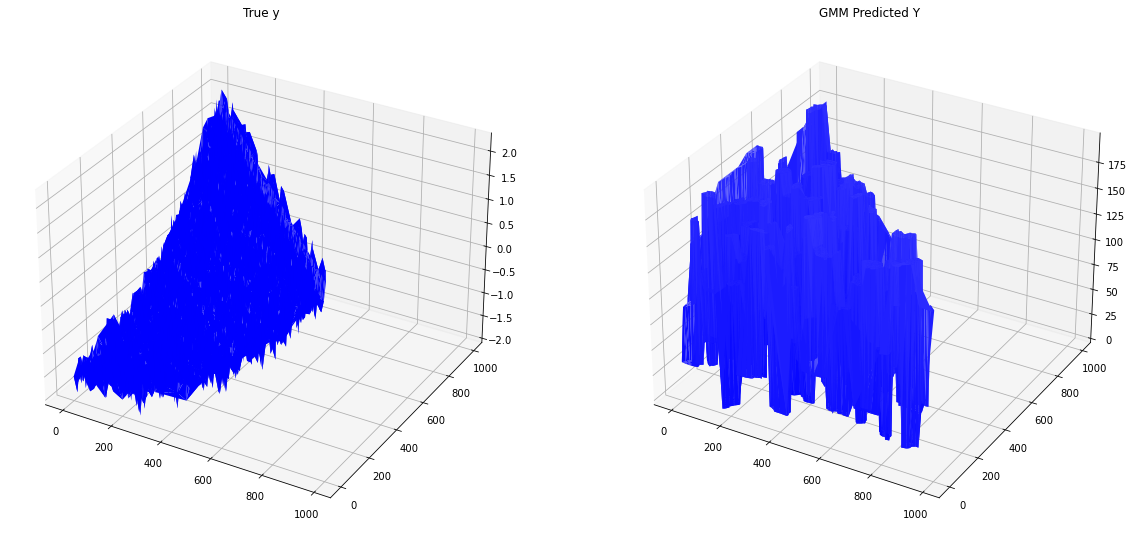

In [30]:
plt.figure(figsize=(20,10))

# True y
plot_gp_2D(X[:, 0], X[:, 1], y, f'True y', 1)

# Gaussian Mixture Model (seems not a good choice)
gmm = GaussianMixture(n_components=200, covariance_type='full').fit(X, y)
Y = gmm.predict(X)

plot_gp_2D(X[:, 0], X[:, 1], Y, f'GMM Predicted Y', 2)

# Test
Y_test = gmm.predict(X_test)
MSE = np.mean(np.power(y_test-Y_test, 2))
print("MSE ", MSE)

MSE  0.0599057494484496
[1.47053762]
[1.33344538]
[1.21571056]
[1.13201432]
[1.09219005]
[1.08560267]


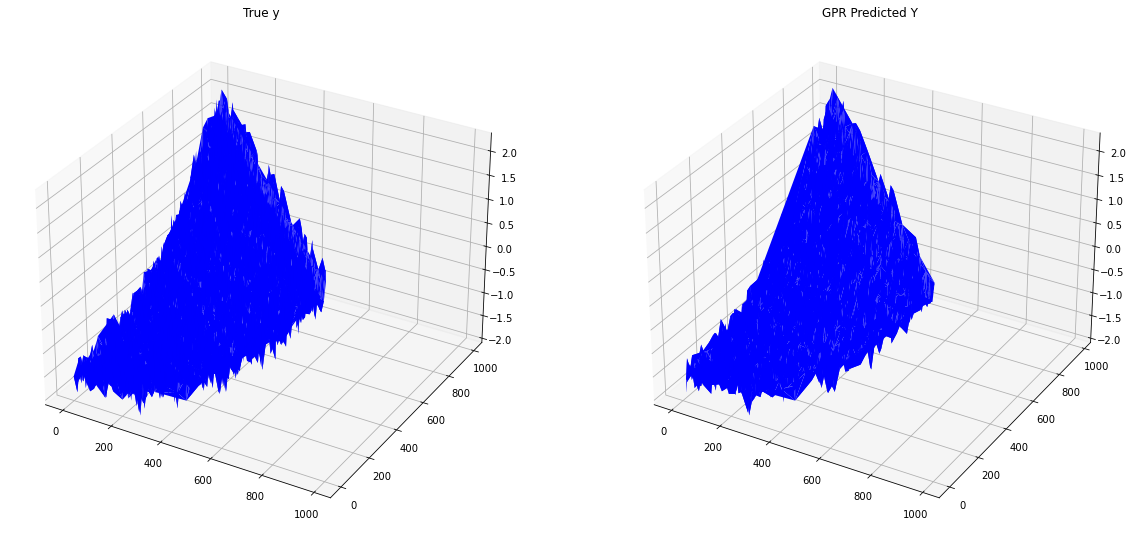

In [35]:
plt.figure(figsize=(20,10))

# True y
plot_gp_2D(X[:, 0], X[:, 1], y, f'True y', 1)

# m52 = kernels.Matern(length_scale=1.0, variance=1.0, nu=2.5)
# gpr = gp.GPRegressor(kernel=m52, noise_level=noise_2D**2, n_restarts=20)

# from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
# kernel = DotProduct() + WhiteKernel()

from sklearn.gaussian_process.kernels import Matern
kernel = 1.0 * Matern(length_scale=1.0, nu=0.5)

# note: we need to reduce the size of the training dataset, otherwise it takes too long to train
X_reduced = X[0:3000]
y_reduced = y[0:3000]

gpr = GaussianProcessRegressor(kernel=kernel, random_state=0).fit(X_reduced, y_reduced)
Y_reduced = gpr.predict(X_reduced)
plot_gp_2D(X_reduced[:, 0], X_reduced[:, 1], Y_reduced, f'GPR Predicted Y', 2)

# Test
Y_test = gpr.predict(X_test)
MSE = np.mean(np.power(y_test-Y_test, 2))
print("MSE ", MSE)

print(gpr.predict(np.array([[550, 337]]))) # train
print(gpr.predict(np.array([[551, 337]])))
print(gpr.predict(np.array([[552, 337]])))
print(gpr.predict(np.array([[553, 337]])))
print(gpr.predict(np.array([[554, 337]])))
print(gpr.predict(np.array([[555, 337]])))

In [39]:
# time benchmark
import time

start_time = time.process_time()

gpr.predict(np.array([[554, 337]]))

end_time = time.process_time()

print("predict time in seconds: ", end_time - start_time)

predict time in seconds:  0.052308540000012727
